In [56]:
# Importing the required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
import pennylane as qml
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import gc

# Set random seed for reproducibility
np.random.seed(42)

In [57]:
# Load Dataset
file_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Datasets\\Darknet.csv"
darknet_data = pd.read_csv(file_path)

# **Model Pre-processing**

In [58]:
# Filter TLS-related traffic
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[(darknet_data['Dst Port'].isin(tls_ports)) & (darknet_data['Protocol'] == 6)]

In [59]:
# Encode categorical data
label_encoder = LabelEncoder()
for column in tls_traffic.select_dtypes(include=['object']).columns:
    tls_traffic[column] = label_encoder.fit_transform(tls_traffic[column])

C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_20060\3250039620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tls_traffic[column] = label_encoder.fit_transform(tls_traffic[column])
C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_20060\3250039620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tls_traffic[column] = label_encoder.fit_transform(tls_traffic[column])
C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_20060\3250039620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [60]:
# Select Numeric Columns
columns_to_exclude = ['Protocol', 'Dst Port', 'Label']
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)

# Optimize Memory
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].astype(np.float32)
gc.collect()

C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_20060\560495277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tls_traffic[numeric_columns] = tls_traffic[numeric_columns].astype(np.float32)


14998

In [61]:
# Handle Missing & Extreme Values
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].clip(lower=tls_traffic[numeric_columns].quantile(0.01),
                                                                 upper=tls_traffic[numeric_columns].quantile(0.99), axis=1)

# Apply MinMax Scaling
tls_traffic[numeric_columns] = MinMaxScaler().fit_transform(tls_traffic[numeric_columns])

C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_20060\773740265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)
C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_20060\773740265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())
C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_20060\773740265.py:4: SettingWith

In [62]:
# Apply SMOTE to handle class imbalance
X = tls_traffic.drop('Label', axis=1)
y = tls_traffic['Label']
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)
tls_traffic = pd.DataFrame(X, columns=X.columns)
tls_traffic['Label'] = y
gc.collect()

0

# **Feature Selection and Feature Importance**

In [63]:
# Feature Selection Process (Newly Added)
correlation_matrix = tls_traffic.corr()
target_correlation = correlation_matrix['Label'].drop('Label')
threshold = 0.14  # Selecting features with absolute correlation > 0.15
selected_features = target_correlation[abs(target_correlation) > threshold]

# Remove identifier columns if they exist
identifiers = ['Flow ID', 'Src IP']
selected_features = selected_features.drop(index=identifiers, errors='ignore')

print("Selected Features Based on Correlation with 'Label':")
print(selected_features)

# Keep only the selected features and the Label
tls_traffic = tls_traffic[selected_features.index.tolist() + ['Label']]
if 'Timestamp' in tls_traffic.columns:
    tls_traffic = tls_traffic.drop(columns=['Timestamp'])
    print("Timestamp feature removed after feature selection!")

Selected Features Based on Correlation with 'Label':
Timestamp                    -0.195451
Flow Duration                 0.142424
Total Fwd Packet              0.157558
Total Bwd packets             0.171535
Total Length of Bwd Packet    0.160211
Fwd Packet Length Max         0.157483
Fwd Packet Length Mean        0.167761
Fwd Packet Length Std         0.140929
Fwd IAT Total                 0.143910
Fwd PSH Flags                 0.182023
Fwd Header Length             0.164551
Bwd Header Length             0.174078
Bwd Packets/s                -0.172950
FIN Flag Count               -0.172485
SYN Flag Count               -0.209288
PSH Flag Count                0.158190
ACK Flag Count                0.167690
Fwd Segment Size Avg          0.167761
Subflow Fwd Bytes             0.153729
FWD Init Win Bytes            0.266273
Bwd Init Win Bytes            0.239926
Fwd Act Data Pkts             0.140888
Fwd Seg Size Min              0.486199
Name: Label, dtype: float64
Timestamp feature remo

In [64]:
# Apply SMOTE to handle class imbalance
X = tls_traffic.drop('Label', axis=1)
y = tls_traffic['Label']
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)
tls_traffic = pd.DataFrame(X, columns=X.columns)
tls_traffic['Label'] = y
gc.collect()

0

In [65]:
# Feature Selection with PCA
pca = PCA(n_components=10)  # Select the top 10 features
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)

In [66]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# **Qiskit Device and Quantum Circuit Intialization**

In [67]:
# Split for quantum & classical inputs
num_qubits = 3
quantum_features = X_train.iloc[:, :num_qubits]  # First 3 features for Quantum
classical_features = X_train.iloc[:, num_qubits:]  # Remaining for Classical

# Define Quantum Circuit
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(num_qubits), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# **Hybrid Quantum-Classical Neural Network**

In [68]:
# Define Quantum Layer
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_qubits, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        self.q_weights = self.add_weight(name="q_weights", shape=(1, num_qubits), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        return tf.random.uniform((tf.shape(inputs)[0], self.num_qubits))

    def get_config(self):
        config = super().get_config()
        config.update({"num_qubits": self.num_qubits})
        return config

# Define Hybrid Model
def create_hybrid_model(num_qubits, num_features, num_classes=4):
    input_q = tf.keras.layers.Input(shape=(num_qubits,))
    input_c = tf.keras.layers.Input(shape=(num_features - num_qubits,))
    
    # Quantum Path
    q_layer = QuantumLayer(num_qubits)(input_q)
    q_layer = tf.keras.layers.Dense(32, activation="relu")(q_layer)

    # Classical Path
    c_layer = tf.keras.layers.Dense(128, activation="relu")(input_c)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.2)(c_layer)
    c_layer = tf.keras.layers.Dense(64, activation="relu")(c_layer)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.2)(c_layer)
    
    # Fusion of Quantum & Classical Features
    combined = tf.keras.layers.concatenate([q_layer, c_layer])
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(combined)

    model = tf.keras.models.Model(inputs=[input_q, input_c], outputs=output)
    return model

hybrid_model = create_hybrid_model(num_qubits, X_train.shape[1])
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss="categorical_crossentropy",
                     metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [69]:
# Split Training & Validation Data
X_train_q, X_val_q, X_train_c, X_val_c, y_train_split, y_val_split = train_test_split(
    quantum_features, classical_features, to_categorical(y_train, num_classes=4),
    test_size=0.2, random_state=42, stratify=y_train
)

In [70]:
# Define Custom Data Generator
class CustomBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_q, X_c, y, batch_size):
        self.X_q = X_q
        self.X_c = X_c
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_X_q = self.X_q[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_c = self.X_c[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X_q, batch_X_c], batch_y

train_generator = CustomBatchGenerator(X_train_q, X_train_c, y_train_split, batch_size=32)
val_generator = CustomBatchGenerator(X_val_q, X_val_c, y_val_split, batch_size=32)

Epoch 1/100
912/912 [==============================] - 2s 1ms/step - loss: 0.4538 - accuracy: 0.8309 - precision: 0.8687 - recall: 0.7910 - val_loss: 0.1333 - val_accuracy: 0.9605 - val_precision: 0.9637 - val_recall: 0.9578
Epoch 2/100
912/912 [==============================] - 1s 1ms/step - loss: 0.1886 - accuracy: 0.9377 - precision: 0.9430 - recall: 0.9323 - val_loss: 0.0767 - val_accuracy: 0.9768 - val_precision: 0.9787 - val_recall: 0.9759
Epoch 3/100
912/912 [==============================] - 1s 1ms/step - loss: 0.1402 - accuracy: 0.9552 - precision: 0.9580 - recall: 0.9527 - val_loss: 0.0646 - val_accuracy: 0.9797 - val_precision: 0.9804 - val_recall: 0.9792
Epoch 4/100
912/912 [==============================] - 1s 1ms/step - loss: 0.1186 - accuracy: 0.9629 - precision: 0.9649 - recall: 0.9606 - val_loss: 0.0601 - val_accuracy: 0.9812 - val_precision: 0.9819 - val_recall: 0.9812
Epoch 5/100
912/912 [==============================] - 1s 1ms/step - loss: 0.1045 - accuracy: 0.9668

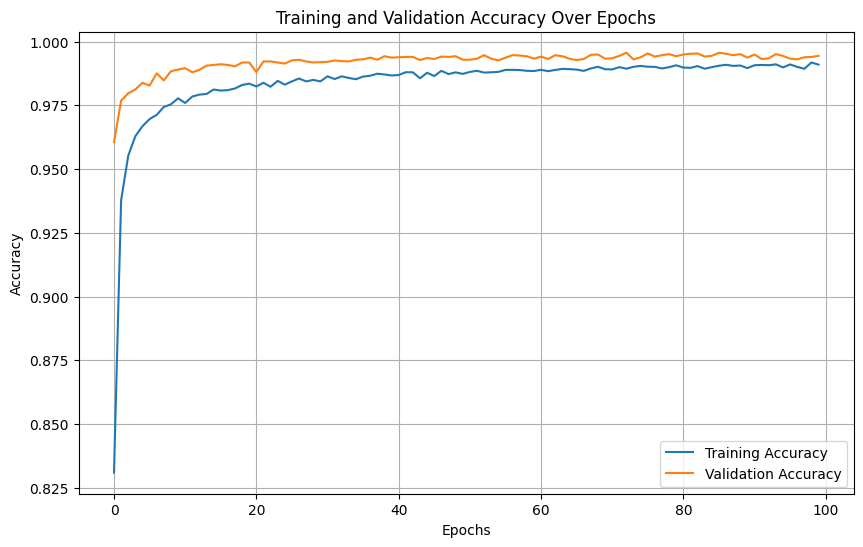

In [71]:
# Train the Model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    verbose=1
)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [72]:
# Predict Malicious TLS Traffic
y_pred_probs = hybrid_model.predict([X_test.iloc[:, :num_qubits], X_test.iloc[:, num_qubits:]])
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract Malicious Traffic (Assuming Label '0' Represents Malicious Traffic)
malicious_traffic = X_test.iloc[np.where(y_pred == 0)].copy()
malicious_traffic['Predicted_Label'] = y_pred[np.where(y_pred == 0)]

# Save Malicious TLS Traffic to CSV
malicious_traffic.to_csv("Malicious_TLS_Traffic.csv", index=False)
print(f"Saved {len(malicious_traffic)} malicious TLS traffic records to 'Malicious_TLS_Traffic.csv'.")

285/285 [==============================] - 0s 523us/step
Saved 2280 malicious TLS traffic records to 'Malicious_TLS_Traffic.csv'.
